# Projet MALARIA




---


# Chargement des données

---


Les données peuvent être téléchargées à partir des liens ci-dessous. Elles ont été mises en forme par rapport aux fichiers d'origine présents sur Kaggle.


Fichiers compressés (".npz") décrivant les annotations

https://drive.google.com/open?id=1DrWP5oWyU0kMZaXlQIqqV3r9lZl4PQmd

https://drive.google.com/open?id=17ZhJ8ALXKuasfa5T0bhJPymymeGJufBb


Archive python (".pkl") contenant les images

https://drive.google.com/open?id=1lQWK4blhmis8cQf8VsqqEYRl-N2XHRAL

https://drive.google.com/open?id=1DShwhXnEm4DEttlJ9gvmpZzGitMgaF8f


Chargez les dans un répertoire accessible de votre drive (ou sur votre ordinateur si vous disposez de ressources de calcul suffisantes).



______

# Paramétrage de Colab
______

Comme dans les TD, on peut utiliser les ressources proposées par Colab. Les données seront stockées sur le Goggle Drive associé à votre compte Gmail.

Pour accéder au données depuis Colab, il faut "monter le Gdrive" depuis une session Colab.

Exécutez le cellule suivante pour le faire. il vous sera demandé de saisir une clé d'authentification générée à partir du lien affiché. (Ctrl+Enter ou clic sur la flèche)

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Il faut ensuite positionner des variables d'environnement pour indiquer à Colab où se trouvent les données (fichiers python et données d'apprentissage).

Exécutez la cellule suivante pour le faire, et modifiez la variable 'TD_DIR' à l'endroit où vous avez sauvegardé le notebook. 

In [0]:
import sys

# Modifier la variable du TD en fonction de l'endroit où les données sont stockées
TD_DIR = 'gdrive/My Drive/data/'

sys.path.append(TD_DIR)



---


# Familiarisation avec les données

---



Le problème à traiter est la classification d'images de cellules pour la détection de la malaria. Les données d'origine sont issues de https://www.kaggle.com/kmader/malaria-bounding-boxes. 

L'image ci-dessous montre un exemple de cytologie révélant des cellules infectées et des saines.

![Image de cytologie](https://storage.googleapis.com/kagglesdsdata/datasets/188282/420762/malaria/images/003a89b0-a095-417a-8dd6-f408339bbc68.png?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1588262841&Signature=YpGGWzADS3LxK0DxkoC8HmCpY8oytdzqczVErkp5DGmPZc0MEH1tApsL3MsYNmN9BDLsakOKq%2BrgHFsslsXMiZnQ%2FjPBUAXOvBqohO3tg4SPKxSSNOEf6GoRff3yLlYM1bxzw2ga7m%2BYha8EnDMpDdRiYTLGE2yZgDbAgbcw8%2Bf56ZFgXalv6cvbe7hEhe5qXmRSccC3%2BoD0mW2Cb5eKh3gTEZFSB6e0wtz2vw04BD88%2BAjYitWNSUoFw4WcMz3sOD5l3FGzbF8yDtOOLyu%2BQ6kpZsUok9tI%2Fg1IE3tQjZup8CqPL3kamsw3695wb%2Ba4dL0xfqVfYMzEDBKlEpKB2w%3D%3D)

Chaque cellule est caractérisée par un type ('gametocyte', 'schizont', 'trophozoite', 'ring', 'leukocyte', 'red blood cell', 'other'), les 4 premiers indiquant une infection.


Pour faciliter la manipulation des données, les cellules individuelles ont été détourées par une boite englobante et organisées en deux jeux: 'sample' et 'test'. Elles ont ensuite été associées à un label binaire: '0' = sain, '1' = infecté et mises à la même taille (128x128).

Les données sont accessibles à partir des fonctions ci-dessous (modifier le répertoire en fonction de l'endroit où vous les aurez déposées).



In [0]:
#Chargement des données

import numpy as np
import matplotlib.pyplot as plt
import string
import pandas as pd
import random
import pickle
import os


datas = np.load(os.path.join(TD_DIR, 'malaria_test_data.npz'))
y_test = datas['gtinfected']
imgs_test = datas['img_names']
bbs_test = datas['bbs']
gt_test = datas['gt']

datas = np.load(os.path.join(TD_DIR, 'malaria_sample_data.npz'))
y_sample = datas['gtinfected']
imgs_sample = datas['img_names']
bbs_sample = datas['bbs']
gt_sample = datas['gt']


with open(os.path.join(TD_DIR, 'test_imagettes_resized.pkl'), 'rb') as f:
    test_imagettes = pickle.load(f)


with open(os.path.join(TD_DIR, 'sample_imagettes_resized.pkl'), 'rb') as f:
    sample_imagettes = pickle.load(f)


Vous disposez d'un outil de visualisation sous la forme de fonctions python ci-dessous.

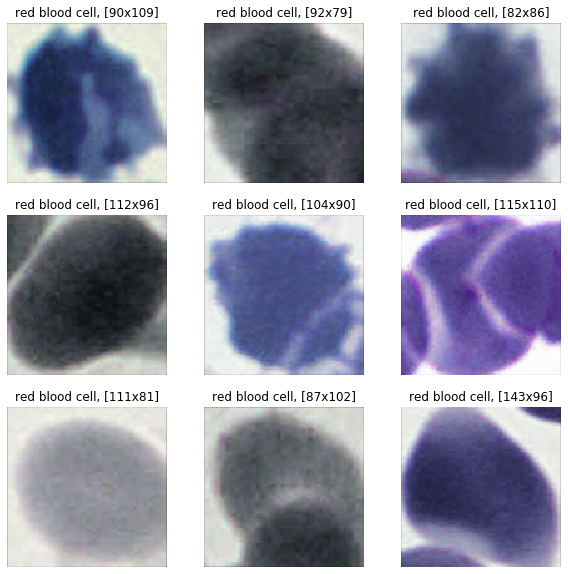

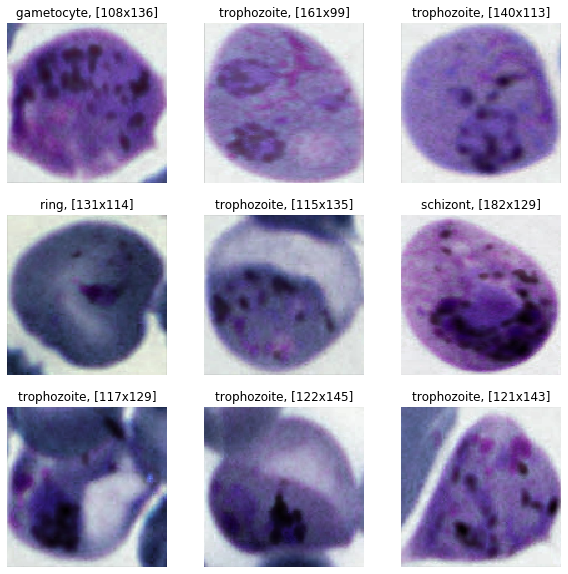

In [0]:
## Fonction de visualisation des cellules
def show_data(imagettes, iselect, gt, bbs, imgs):
    fig, axes = plt.subplots(3, 3, figsize=(10,10))
    for ax in axes.flat:
        isample = iselect[np.random.randint(iselect.shape[0])]
        #img = imread(imgs[isample])
        bb = bbs[isample]
        crop = imagettes[isample]
        ax.imshow(crop)
        ax.axis('off')
        ax.set_title("{}, [{}x{}]".format(gt[isample], bb[2]-bb[0], bb[3]-bb[1]))
    
    plt.show()


show_data(sample_imagettes, (y_sample == 0).nonzero()[0], gt_sample, bbs_sample, imgs_sample)
show_data(sample_imagettes, (y_sample == 1).nonzero()[0], gt_sample, bbs_sample, imgs_sample)
        


---


# Classification sain/infecté

---

Pour résoudre le problème, il y a principalement deux stratégies possibles:
- Extraire des caractéristques discriminantes sur les images puis appliquer un classifieur. La difficulté est de trouver et de calculer ces caractéristiques.
- Utiliser une chaîne "Deep Learning" qui calcule automatiquement les caractéristiques lors de l'apprentissage. La difficulté est de trouver la bonne architecture et de contrôler l'apprentissage. On peut aussi utiliser des réseaux pré-appris et les adapter aux données du problème.

## Point de connaissance : Courbes ROC

Pour éviter les effets du déséquilibre entre données dans les performances, on se propose d'évaluer le prédicteur sur un ensemble de points de fonctionnement (courbe ROC ou ["Receiver Operating Characteristic"](https://en.wikipedia.org/wiki/Receiver_operating_characteristic))

On pourra utiliser la fonction [`roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve) dans `scikit-learn`. L'aire sur la courbe, qui résume par un scalaire les différents points de fonctionnement, se calcule par la fonction [`roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score).



C'est à vous maintenant...
